CS575 Applied Time Series Analysis - Mini Project (April 2021)

Submitted by - 2121CS07, Nelson Sharma

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# __ install statsmodels==0.12.2

In [ ]:
pip install statsmodels==0.12.2

     |████████████████████████████████| 9.5MB 5.2MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
pip show statsmodels

# [] IMPORTS []

In [ ]:
import datetime
import os
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.tsa as tsa
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Dense, RepeatVector, TimeDistributed, Flatten, LSTM

from tensorflow.keras import Model

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)


# [] GLOBAL []

In [ ]:
MITDB_SEL_REC = ['116','215','210','233','214','228','221','119','203','106']

_SEL_REC = ['I54']
##############################################################################################################################3
# global variables
##############################################################################################################################3
# Resampled every signal to this rate for consistency
BASIC_SRATE = 128 #Hz
print('Basic sampling rate(Hz):',BASIC_SRATE)

DATASET_DIR = '/content/drive/MyDrive/cs575_mini_project/dataset'
print('DATASET DIR ::',DATASET_DIR)

DATASET_DIR_NPY = '/content/drive/MyDrive/cs575_mini_project/db_npy'
print('DATASET_NPY DIR ::',DATASET_DIR_NPY)

# std annotation 
std_annotations = os.path.join(DATASET_DIR,'ANTS.txt')
print('STD ANN FILE ::',std_annotations)

# >------ load standard labels ------------------------------------------
std_ant = np.loadtxt(std_annotations, dtype='str',delimiter="\t")
# <------ load standard labels ------------------------------------------

#-----------------------------------------------------------------------------
# Seperate out stand beat and non-beat annotations using 'annotations.txt'
beat_ants = []
non_beat_ants = []
print('\nStandard Labels::')
for a in std_ant:
    # a[0] =  # standard label (char)
    # a[1] =  # type of label
    # a[2]  = # description (str)
    print(a[0]+'\t'+a[1]+'\t'+a[2])
    if a[1]=='b': #<<--- is a beat-annotation
        beat_ants.append(a[0])
    else:
        non_beat_ants.append(a[0])

print('')
print('beat-annotation:',len(beat_ants))
print('non-beat-annotation:',len(non_beat_ants))
#-----------------------------------------------------------------------------

#-----------------------------------------------------------------------------
# data file identifiers 
g_BEAT = '_BEAT.npy'         #<<--- beat annotations
g_NBEAT = '_NBEAT.npy'       #<<--- non-beat annotations
g_SIG2 = '_SIG_II.npy'     #<<--- Signal Data (Removed manual gain)
#-----------------------------------------------------------------------------
# define a mapping dictionary
custom_ants = [ '_N','_S','_V','_F','_Q']
custom_cols = { '_N':'tab:green',
               '_S':'tab:red',
               '_V':'tab:blue',
               '_F':'tab:purple',
               '_Q':'tab:pink'}
custom_mapping = {
                    'N': '_N',
                    'L': '_N',
                    'R': '_N',
                    'B': '_N',
                    'A': '_S',
                    'a': '_S',
                    'J': '_S',
                    'S': '_S',
                    'V': '_V',
                    'r': '_V',
                    'F': '_F',
                    'e': '_S',
                    'j': '_S',
                    'n': '_S',
                    'E': '_V',
                    'f': '_Q',
                    '/': '_Q',
                    'Q': '_Q',
                    '?': '_Q',
                }

##############################################################################################################################3
# CLASS DEFS
##############################################################################################################################3
#REC_MINt, REC_MAXt = 0, 1800
#REC_MINs, REC_MAXs = REC_MINt*BASIC_SRATE, REC_MAXt*BASIC_SRATE
class ecgDatabase:
    def __init__(self, db_name, db_path):
        self.db_name = db_name
        self.db_path = db_path
        self._prepare()
        
    def _prepare(self):
        self.record_list = np.loadtxt(os.path.join(self.db_path,'RECORDS'), dtype='str',delimiter="\n")
        if len(self.record_list.shape)==0:
            self.record_list = np.array([self.record_list])
        # prepare a dictionary of ecgRecord objects
        self.records = {}
        for irec in self.record_list:
            self.records[irec] = ecgRecord(irec,os.path.join(self.db_path))
        #print('Prepared', len(self.records.keys()), 'records')
        return
        
    def get_record(self, rec_name):
        if rec_name in self.records.keys():
            this_rec = self.records[rec_name]
            if not this_rec.isloaded:
                this_rec.loadfromdisk()
            return this_rec
        else:
            return None
        
class ecgRecord:
    def __init__(self, arg_recname, arg_path):
        self.path = arg_path
        self.name = arg_recname
        self.isloaded = False
        

    def loadfromdisk(self):
        #print('\nLoading Record:', self.name)
        
        #<<---------------------------------------------
        # Load Signal Data
        #<<---------------------------------------------
        self.signal_file = os.path.join(self.path,self.name + g_SIG2)
        self.iSignal = np.load(self.signal_file)
        #print('Signal Length =',self.iSignal.shape)
        #print('Signal Duration =',len(self.iSignal)/BASIC_SRATE, 'sec')
        
        #<<---------------------------------------------
        # Load Beat-Annotation (Labels)
        #<<---------------------------------------------
        self.beat_file = os.path.join(self.path,self.name + g_BEAT)
        self.iBeat = np.load(self.beat_file)
        #print('beats:',self.iBeat.shape)
        # seperate out R-peaks and Labels (note both are in string format)
        self.iRpeaks = self.iBeat[:,0].astype('int') #<<-- convert sampling locations to integer
        self.iLabels = self.iBeat[:,1]               #<<-- labels remain as string
        self.nos_beats = len(self.iRpeaks)
        #<<---------------------------------------------
        # Load Non-Beat-Annotation
        #<<---------------------------------------------
        #nbeat_file = os.path.join(idbPath,iRecord + g_NBEAT)
        #iNbeat = np.load(nbeat_file)
        #print('non-beats:',iNbeat.shape)
        # seperate out R-peaks and non-beats (note both are in string format)
        #inRpeaks = iNbeat[:,0].astype('int') #<<-- convert sampling locations to integer
        #inLabels = iNbeat[:,1] #<<-- labels remain as string
        #<<---------------------------------------------
        # assign object vars
        #<<---------------------------------------------

        self.isloaded = True
        return self.isloaded

    # for mapping custom labels   ** rec.mLabels = rec.map_beat_labels(custom_mapping)
    def map_beat_labels(self, aami_mapping):
        iLabels = np.zeros(len(self.iLabels), dtype='U2')       
        for i in range(0,len(self.iLabels)):
            iLabels[i]=aami_mapping[self.iLabels[i]]
        return iLabels

    def get_beats_indices_of_label(self, self_label_list, lable_to_find):
        #return np.where(((self.iRpeaks >= pf) & (self.iRpeaks < pt) & (self_label_list==lable_to_find)))[0]
        return np.where( (self_label_list==lable_to_find) )[0]
        
    def get_signal_slice_fd(self,pf, pt):
        signal_slice = self.iSignal[pf:pt]
        signal_list = np.where((self.iRpeaks>=pf) & (self.iRpeaks<pt))[0]
        return signal_slice, signal_list

    def get_signal_slice_rri(self, Rpeaki, minus_i, plus_i ,signal_pad_left, signal_pad_right ):
        RpeakL = self.iRpeaks[Rpeaki-minus_i]+signal_pad_left
        RpeakC = self.iRpeaks[Rpeaki]
        RpeakR = self.iRpeaks[Rpeaki+plus_i]-signal_pad_right
        pf,pt = RpeakL,RpeakR
        signal_slice=self.iSignal[pf:pt]
        signal_list = np.where((self.iRpeaks>=pf) & (self.iRpeaks<pt))[0]
        return signal_slice, signal_list, pf, pt

    def get_signal_slice_rri_1(self, Rpeaki, minus_i, plus_i ,signal_pad_left, signal_pad_right ):
        return self.iSignal[self.iRpeaks[Rpeaki-minus_i]+signal_pad_left:self.iRpeaks[Rpeaki+plus_i]-signal_pad_right]
#-------------------------------------------------------------------------------------------------------------------
#    def get_signal_slice_ap(self, Rpeak, left_samples, right_samples ):
#        signal_slice = self.iSignal[Rpeak-left_samples:Rpeak+right_samples]
#        Rpeaki = np.where(self.iRpeaks==Rpeak)[0][0]
#        return signal_slice, Rpeaki
    def get_signal_slice_api(self, Rpeaki, left_samples, right_samples ):
        Rpeak = self.iRpeaks[Rpeaki]
        signal_slice = self.iSignal[Rpeak-left_samples:Rpeak+right_samples]
        return signal_slice, Rpeaki
#-------------------------------------------------------------------------------------------------------------------

##############################################################################################################################3
# TSA
##############################################################################################################################3
# <<---------------- define adf and kpss testing
def adf_test(timeseries, p_threshold , max_lags=None, details = False):
  res=""
  res += '\nADF-Test Hypothesis \t Series is Non-Stationary\n'
  dftest =  tsa.stattools.adfuller(timeseries,  regression='c', maxlag=max_lags, autolag=None )
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] =  (value, getHres(dftest[0],value) )

  if details:
    res+=str(dfoutput)+"\n"
  #if dftest[1]<p_threshold: # hypothesis is false = Rejected
  #if dftest[1]>p_threshold: # hypothesis is true = cannot reject
  resb =  (dftest[1]>=p_threshold)
  res+= "ADF-Test Result \t "+str( resb )
  
  return res, resb, dftest[1]

def getHres(test_stat, crit_val):
  if test_stat<crit_val:
    return "Hypothesis: False"
  else:
    return "Hypothesis: True"

#%%

# plot Autocorr and Partial Autocorr ------------------

def plotCF(Y, Lags, include_L0):
  fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
  plot_acf(Y,lags=Lags,zero=include_L0,ax=ax1)
  plot_pacf(Y,lags=Lags,zero=include_L0,ax=ax2)
  plt.show()
  
# TS analysis
def TSA(signal_slice, eo):
    
    data = pd.Series( (signal_slice))
    model_ARIMA = ARIMA(endog=signal_slice, order=eo)
    result_ARIMA = model_ARIMA.fit()
    return model_ARIMA, result_ARIMA
#%%

# <<----------------  define performace params
def get_MSE(e,s):
  N=len(e)
  return np.sum((e-s)**2)/N


##############################################################################################################################3
# PERF
##############################################################################################################################3

#===============================================================
# PERFORMANCE =================================================
#===============================================================
#------------------------------------------------------------------
# Confusion Matrix
#------------------------------------------------------------------
def _print_header(class_labels):
    g_HSTR=''   # HEADER ROW for printing confusing matrix
    for i in range(0,len(class_labels)):
        g_HSTR+='\t'+str(class_labels[i])
    return  g_HSTR
def _print_rows(cm_row, nos_labels):
    g_RSTR = ''
    for j in range(0,nos_labels):
        g_RSTR += '\t'+ str(cm_row[j])
    return g_RSTR
def print_conf_matrix(conf_matrix, suffix, class_labels):
    g_CMSTR=(suffix+'T\\P' + _print_header(class_labels)+'\n')
    nos_l=len(class_labels)
    for i in range(0,nos_l):
        g_CMSTR+=(suffix+str(class_labels[i]) + _print_rows(conf_matrix[i],nos_l )+'\n')
    return g_CMSTR

#------------------------------------------------------------------
# Performance Measures
#------------------------------------------------------------------
def _get_performance(conf_matrix):
    nos_class = len(conf_matrix[0,:]) # len of 0th row
    perf_measures_array = np.zeros((0,11),dtype ='float64')
    for i in range(0,nos_class):
        
        CLASS_ACTUAL = np.sum(conf_matrix[i,:]) #<---- ROW SUM = NOS TRUE CLASS
        CLASS_PRED = np.sum(conf_matrix[:,i])      #<---- COL SUM = NOS PRED CLASS
        MSUM = np.sum(conf_matrix)  # = TP + FN + FP + TN
        
        # compute TP, TN, FP, FN ---------------------------- 
        TP = conf_matrix[i,i]
        FP =  CLASS_PRED - TP
        FN = CLASS_ACTUAL - TP
        TN =  MSUM- FN - FP - TP #<------------ this methods counts more than true negative
        #TN = np.sum(conf_matrix[np.diag_indices(nos_class)]) - TP..

        #Accuracy #<-= how many samples correctly classifed out of all samples
        ACC = (TP+TN)   /   ( MSUM)  
        
        #Precision = TP/CLASS_PRED    #<- = how many samples correctly predicted as true out of all samples predicted as true
        PRE = (TP)      /   (TP+FP)         #Presicion
        
        #Sensetivity = TP/CLASS_ACTUAL #<- = how many samples correctly predicted as true out of all actually true samples
        SEN = (TP)      /   (TP+FN)         #Sensitivity/Recall
        
        #Specificity #<-= how many samples correctly predicted false out of all samples predicted as false
        SPF = (TN)      /   (TN+FP)         
        
        # F1-Score #<-= 2*TP / (CLASS_ACTUAL + CLASS_PRED) 
        F1S = 2*PRE*SEN /   (PRE+SEN)       #F1 score #<-= harmonic mean of Precision and Sensetivity

        prefi = np.array([CLASS_ACTUAL , CLASS_PRED, TP, FN, FP, TN, ACC, PRE, SEN, SPF, F1S])
        perf_measures_array = np.vstack((perf_measures_array,prefi))
        
    return perf_measures_array, nos_class
def print_performance(conf_matrix, class_labels, do_round=-1):
    #header_string = 'Class\tACC\tPRE\tSEN\tSPF\tF1S'
    header_string = 'Class\t#True\t#Pred\tTPs\tFNs\tFPs\tTNs\tACC\tPRE\tSEN\tSPF\tF1S'
    perf_measures, nos_class = _get_performance(conf_matrix)
    if len(class_labels)!=nos_class:
        print('WARNING:: Class label count mismatch!! Cannot print performance')
        return -1
    #nos_class = len(perf_measures[:,0])
    print('Performance for '+str(nos_class)+' classes')
    print (header_string)
    for i in range(0, nos_class):
        if do_round<0:
          perf_i = perf_measures [i,:]
        else:
          perf_i = np.round(perf_measures [i,:],do_round)
          
        print(
              str(class_labels[i])+'\t'+
              str(perf_i[0])+'\t'+
              str(perf_i[1])+'\t'+
              str(perf_i[2])+'\t'+
              str(perf_i[3])+'\t'+
              str(perf_i[4])+'\t'+
              str(perf_i[5])+'\t'+
              str(perf_i[6])+'\t'+
              str(perf_i[7])+'\t'+
              str(perf_i[8])+'\t'+
              str(perf_i[9])+'\t'+
              str(perf_i[10])
              )
    return nos_class
	

Basic sampling rate(Hz): 128
DATASET DIR :: /content/drive/MyDrive/cs575_mini_project/dataset
DATASET_NPY DIR :: /content/drive/MyDrive/cs575_mini_project/db_npy
STD ANN FILE :: /content/drive/MyDrive/cs575_mini_project/dataset/ANTS.txt

Standard Labels::
N	b	Normal beat
L	b	Left bundle branch block beat
R	b	Right bundle branch block beat
B	b	Bundle branch block beat (unspecified)
A	b	Atrial premature beat
a	b	Aberrated atrial premature beat
J	b	Nodal (junctional) premature beat
S	b	Supraventricular premature or ectopic beat (atrial or nodal)
V	b	Premature ventricular contraction
r	b	R-on-T premature ventricular contraction
F	b	Fusion of ventricular and normal beat
e	b	Atrial escape beat
j	b	Nodal (junctional) escape beat
n	b	Supraventricular escape beat (atrial or nodal)
E	b	Ventricular escape beat
/	b	Paced beat
f	b	Fusion of paced and normal beat
Q	b	Unclassifiable 
?	b	Beat not classified during learning
[	n	Start of ventricular flutter/fibrillation
!	n	Ventricular flutter wave
]	n

# [] METHOD #1 - Linear []

## LA Classifier

In [ ]:
class LAEncoder:
    def __init__(self, arg_name, minus_i, plus_i, signal_padl, signal_padr, arima_eo):
        self.name = arg_name
        self.mi, self.pi = minus_i, plus_i
        self.spl, self.spr = signal_padl,signal_padr
        self.arima_tuple = arima_eo
        

    def do_encode(self, rec, bindex, nlabel):
        signal = rec.get_signal_slice_rri_1(bindex, self.mi, self.pi, self.spl, self.spr)
        mtsa, rtsa = TSA(signal, self.arima_tuple) # (depends,1,depends_q)
        encoded_ = np.hstack((rtsa.params,nlabel))
        return encoded_
    #######################################################

class LAClassifier:
    def __init__(self, arg_name, arg_encoder, arg_Nlabel, arg_Alabel):
        self.name = arg_name
        self.encoder = arg_encoder
        self._n = arg_Nlabel
        self._a = arg_Alabel
        
    def _do_begin(self, rec, B_):
        print('Begin on rec:',rec.name,B_.shape)
        data_hist = []

        for ii in range(0,len(B_)):
            i=B_[ii]
            if rec.mLabels[i]==self._n:
                lab=0
            elif rec.mLabels[i]==self._a:
                lab=1
            else:
                print('label not learned, skipping beat @index', i, ' label =',rec.mLabels[i])
                continue

            #print('Encoding...')
            encoded_beat = self.encoder.do_encode(rec, i, lab)
            

            #print('LDA...')
            lda_x, lda_y = np.expand_dims(encoded_beat[0:-1],axis=0), encoded_beat[-1]
            #lda_xx1,lda_xx2 = self.lda1.transform(lda_x),self.lda2.transform(lda_x)

            pb1, pb2=self.lda1.predict(lda_x),self.lda2.predict(lda_x)
            data_hist.append(np.hstack((encoded_beat,pb1,pb2)))
            #predictions_prog=np.argmax(self.MLPmodel.predict(lda_xx2), axis=-1)
            print(ii, '#'+str(i),'\tTrue:',lab,'\tPred:',pb1,pb2)

        print('End of record interval')
        return data_hist
        
    

    def do_init(self, rec,  use_beats=10, use_mapped_labels = True, random_train_beats=True):

        print('Init Classifier...')
        # <<-- Choose NN and AA
        if use_mapped_labels:
            print('Use mapped labels')
            mLabels_p,mLabels_c,mLabels_n = rec.mLabels[0:-2],rec.mLabels[1:-1],rec.mLabels[2:]
        else:
            print('Use original labels')
            mLabels_p,mLabels_c,mLabels_n = rec.iLabels[0:-2],rec.iLabels[1:-1],rec.iLabels[2:]

        ##############################################################################################################

        NN_ = np.where((mLabels_p==self._n)&(mLabels_c==self._n)&(mLabels_n==self._n))[0]+1 # True Normal:
        #N_ = np.where((mLabels_c==self._n))[0]+1 # Any Normal: All Normal beats
        #AA_ = np.where((mLabels_c!=self._n))[0] + 1 # All Abnormal beats
        A_ = np.where((mLabels_c==self._a))[0] + 1 # Abnormal beats

        nncount = min(len(NN_),use_beats)
        aacount = min(len(A_),use_beats)

        # either take from begin or randomly
        if random_train_beats:
            print('Random beats for training...')
            for_train_N = np.random.choice(NN_,size=nncount,replace=False)  #<--- rand True Normal
            for_train_A = np.random.choice(A_,size=aacount,replace=False)  #<--- rand Abnormal beats
        else:  
            print('Initial beats for training...')  
            for_train_N = NN_[0:nncount]  #<--- first 10 beats True Normal
            for_train_A = A_[0:aacount]  #<--- first 10 beats Abnormal beats

        self.skip_beats = use_beats

        self.data_listN=[]
        self.data_listA=[]
        print('Encoding...',nncount,aacount )
        # initialize lda
        for i in range(0,nncount):
            self.data_listN.append(self.encoder.do_encode(rec, for_train_N[i], 0))
        for i in range(0,aacount):
            self.data_listA.append(self.encoder.do_encode(rec, for_train_A[i], 1))
        
        
        # first choose use_beats

        data_ = np.vstack((np.array(self.data_listN),np.array(self.data_listA)))
        np.random.shuffle(data_)

        

        #print('LDA...') #LDA(n_components=1)
        lda_x, lda_y = data_[:,0:-1], data_[:,-1]
        self.lda1 = LDA(solver='eigen', shrinkage=None,store_covariance=True)  #shrinkage='auto'
        self.lda2 = LDA(solver='svd', shrinkage=None, store_covariance=True)

        clf1, clf2 = self.lda1.fit(lda_x, lda_y), self.lda2.fit(lda_x, lda_y)
        print('LDA_1:', clf1.score(lda_x, lda_y))
        print('LDA_2:', clf2.score(lda_x, lda_y))
 
        lda_xx1, lda_xx2 = self.lda1.transform(lda_x), self.lda2.transform(lda_x)
        #print('COV1',self.lda1.classes_ ,'\n', )

        #print('COV2',self.lda2.classes_ ,'\n',self.lda2.covariance_ )


#------>>> X_testF = lda.transform(X_train)
        x_0,x_1 = np.where(lda_y==0)[0],np.where(lda_y==1)[0]
        xt_0,xt_1 = lda_xx1[x_0],lda_xx1[x_1]
        #plt.figure(figsize=(12,4))
        
        #plt.show()

        x_02,x_12 = np.where(lda_y==0)[0],np.where(lda_y==1)[0]
        xt_02,xt_12 = lda_xx2[x_02],lda_xx2[x_12]
        #plt.figure(figsize=(12,4))

        fig,ax = plt.subplots(1,2, figsize=(8,4))
        ax[0].imshow(self.lda1.covariance_)
        ax[0].set_title('Covariance Matrix - LDA 1')
        ax[1].scatter( x_0,xt_0, color='tab:green', marker='.' )
        ax[1].scatter( x_1,xt_1, color='tab:red', marker='.' )
        ax[1].set_title('Transformed Data - LDA 1')
        #plt.legend()
        plt.show()


        fig,ax = plt.subplots(1,2, figsize=(8,4))
        ax[0].imshow(self.lda2.covariance_)
        ax[0].set_title('Covariance Matrix - LDA 2')
        ax[1].set_title('Transformed Data - LDA 2')
        ax[1].scatter( x_02,xt_02, color='tab:green', marker='.' )
        ax[1].scatter( x_12,xt_12, color='tab:red', marker='.')
        #plt.legend()

        plt.show()

        
        return self.skip_beats, self.lda1, self.lda2





## Select Dataset

In [ ]:
print(os.listdir(DATASET_DIR))
print(os.listdir(DATASET_DIR_NPY))

In [ ]:
sel_db_name = 'mitdb_npy'
sel_db_path = os.path.join(DATASET_DIR_NPY, sel_db_name)
sel_db_files = os.listdir(sel_db_path)
print(sel_db_path,',', len(sel_db_files) )

dbo = ecgDatabase(sel_db_name, sel_db_path)
print(dbo.record_list.shape,dbo.record_list)

/content/drive/MyDrive/cs575_mini_project/db_npy/mitdb_npy , 144
(43,) ['100' '101' '103' '105' '106' '108' '109' '111' '112' '113' '114' '115'
 '116' '117' '118' '119' '121' '122' '123' '124' '200' '201' '202' '203'
 '205' '208' '209' '210' '212' '213' '214' '215' '219' '220' '221' '222'
 '223' '228' '230' '231' '232' '233' '234']


## Select Record

In [ ]:
recn = '214' # ['116', '215', '210', '233', '214', '228', '221', '119', '203', '106']
rec = dbo.get_record(recn)
print(rec.name, '\t'+str(rec.nos_beats)+ ' beats')
rec.mLabels = rec.map_beat_labels(custom_mapping)# <<-- custom lables

214 	2262 beats


## Set Params

In [ ]:
arima_param = (4,1,4) # (p,d,q)
mi,pi,spl,spr = 0,1,-32,32    # minus_i, plus_i ,signal_pad_left, signal_pad_right (in samples)
Lab_N, Lab_V = "_N","_V"
training_beats = 80        # beats to initialize - train on each type - total 2x
print('arima param:',arima_param)
print('signal slice params:',mi,pi,spl,spr)

arima param: (4, 1, 4)
signal slice params: 0 1 -32 32


## Train Classifier

Init Classifier...
Use mapped labels
Random beats for training...
Encoding... 80 80
LDA_1: 0.9125
LDA_2: 0.9125


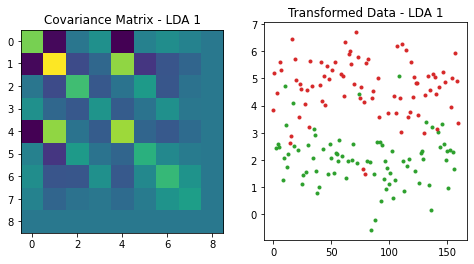

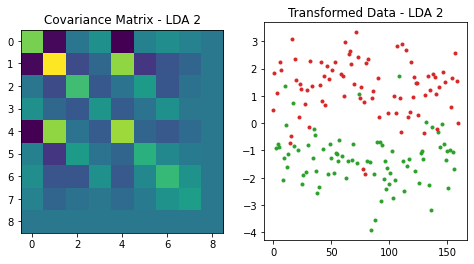

In [ ]:
xEncoder = LAEncoder("encoder_1", mi,pi,spl,spr,arima_param)
xClassifier = LAClassifier("classifier_1", xEncoder, Lab_N, Lab_V)
rskip_beats, rlda, rMLPmodel = xClassifier.do_init(rec,
                                                          use_beats=training_beats, 
                                                          use_mapped_labels = True
                                                          )


## Test

In [ ]:
timestamp_start = datetime.datetime.now()

mLabels_c = rec.mLabels[1:-1]
q = np.hstack(( np.random.choice( np.where((mLabels_c=="_V"))[0]+1, size= 100,replace=False),
 np.random.choice( np.where((mLabels_c=="_N"))[0]+1, size= 100,replace=False)))
print("...begin encoding and prediction on samples:",len(q))
data_hist_r = xClassifier._do_begin(rec, q)

print('\nElapsed time = ',datetime.datetime.now() - timestamp_start)

...begin encoding and prediction on samples: 200
Begin on rec: 214 (200,)
0 #288 	True: 1 	Pred: [1.] [1.]
1 #1881 	True: 1 	Pred: [1.] [1.]
2 #216 	True: 1 	Pred: [1.] [1.]
3 #1310 	True: 1 	Pred: [0.] [0.]
4 #2224 	True: 1 	Pred: [1.] [1.]
5 #189 	True: 1 	Pred: [1.] [1.]
6 #2218 	True: 1 	Pred: [1.] [1.]
7 #2151 	True: 1 	Pred: [1.] [1.]
8 #442 	True: 1 	Pred: [1.] [1.]
9 #957 	True: 1 	Pred: [1.] [1.]
10 #325 	True: 1 	Pred: [0.] [0.]
11 #1738 	True: 1 	Pred: [1.] [1.]
12 #220 	True: 1 	Pred: [1.] [1.]
13 #1576 	True: 1 	Pred: [1.] [1.]
14 #1741 	True: 1 	Pred: [1.] [1.]
15 #707 	True: 1 	Pred: [1.] [1.]
16 #674 	True: 1 	Pred: [1.] [1.]
17 #1182 	True: 1 	Pred: [1.] [1.]
18 #1754 	True: 1 	Pred: [1.] [1.]
19 #772 	True: 1 	Pred: [1.] [1.]
20 #334 	True: 1 	Pred: [1.] [1.]
21 #1573 	True: 1 	Pred: [1.] [1.]
22 #379 	True: 1 	Pred: [1.] [1.]
23 #1063 	True: 1 	Pred: [1.] [1.]
24 #645 	True: 1 	Pred: [1.] [1.]
25 #206 	True: 1 	Pred: [1.] [1.]
26 #1491 	True: 1 	Pred: [1.] [1.]
27 #1

## Result [LDA_1]


	Confusion Matrix [N/A]
T\P	0	1
0	95	5
1	9	91

Performance for 2 classes
Class	#True	#Pred	TPs	FNs	FPs	TNs	ACC	PRE	SEN	SPF	F1S
0	100.0	104.0	95.0	5.0	9.0	91.0	0.93	0.91346	0.95	0.91	0.93137
1	100.0	96.0	91.0	9.0	5.0	95.0	0.93	0.94792	0.91	0.95	0.92857

Total Predictions	 200
Correct Predictions	 186 	 93.0 %
Incorrect Predictions	 14 	 7.0 %


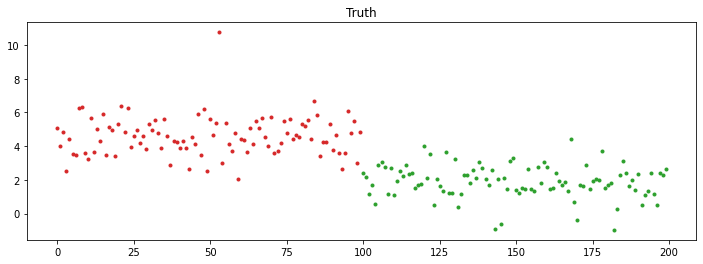

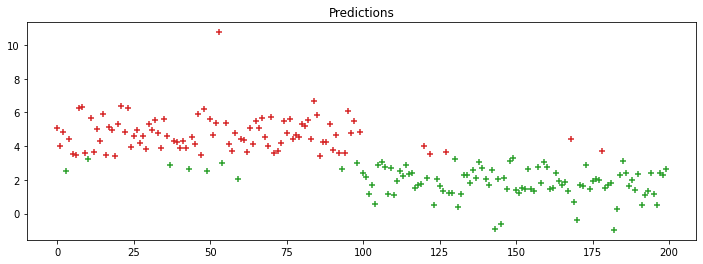

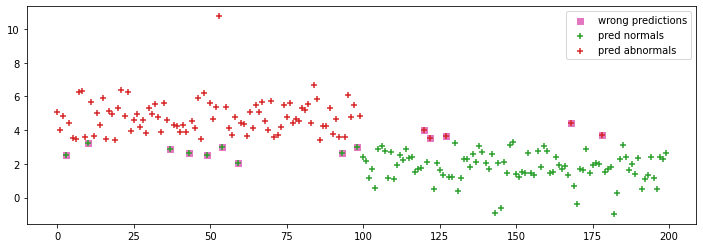

In [ ]:
##############################################################################################
res_ = np.array(data_hist_r)
g_LABELS = np.array([0,1])
res_pred_y = res_[:,-2]
res_true_y = res_[:,-3]
res_x = res_[:,0:-3]


matrix = confusion_matrix( res_true_y,  res_pred_y,   g_LABELS )
print('\n\tConfusion Matrix [N/A]')
print(print_conf_matrix( matrix, '', g_LABELS))
print_performance( matrix ,g_LABELS, do_round=5)

pred_correct = np.where(res_pred_y==res_true_y)[0]
pred_wrong = np.where(res_pred_y!=res_true_y)[0]
pC = len(pred_correct)
pW = len(pred_wrong)
print('')
assert ((pC+pW)==len(res_true_y))
print('Total Predictions\t',(pC+pW))
print('Correct Predictions\t', pC,'\t', round((100*pC)/(pC+pW),2),'%')
print('Incorrect Predictions\t', pW,'\t', round((100*pW)/(pC+pW),2),'%')

##############################################################################################
RT = xClassifier.lda1.transform(res_x)

x_0,x_1 = np.where(res_true_y==0)[0],np.where(res_true_y==1)[0]
xt_0,xt_1 = RT[x_0],RT[x_1]
plt.figure(figsize=(12,4))
plt.title('Truth')
plt.scatter( x_0,xt_0, color='tab:green', marker='.' )
plt.scatter( x_1,xt_1, color='tab:red', marker='.' )
plt.show()

x_0p,x_1p = np.where(res_pred_y==0)[0],np.where(res_pred_y==1)[0]
xt_0p,xt_1p = RT[x_0p],RT[x_1p]
plt.figure(figsize=(12,4))
plt.title('Predictions')
plt.scatter( x_0p,xt_0p, color='tab:green', marker='+' )
plt.scatter( x_1p,xt_1p, color='tab:red', marker='+' )
plt.show()

x_0p,x_1p = np.where(res_pred_y==0)[0],np.where(res_pred_y==1)[0]
xt_0p,xt_1p = RT[x_0p],RT[x_1p]
plt.figure(figsize=(12,4))

plt.scatter( pred_wrong,RT[pred_wrong], color='tab:pink', marker='s', label='wrong predictions' )
#plt.scatter( pred_correct,RT[pred_correct], color='black', marker='.' )
#plt.scatter( x_0,xt_0, color='tab:green', marker='x',label='true normals' )
#plt.scatter( x_1,xt_1, color='tab:red', marker='x',label='true normals' )
plt.scatter( x_0p,xt_0p, color='tab:green', marker='+' , label='pred normals')
plt.scatter( x_1p,xt_1p, color='tab:red', marker='+', label='pred abnormals' )

plt.legend()
plt.show()

## Result [LDA_2]


	Confusion Matrix [N/A]
T\P	0	1
0	99	1
1	1	99

Performance for 2 classes
Class	#True	#Pred	TPs	FNs	FPs	TNs	ACC	PRE	SEN	SPF	F1S
0	100.0	100.0	99.0	1.0	1.0	99.0	0.99	0.99	0.99	0.99	0.99
1	100.0	100.0	99.0	1.0	1.0	99.0	0.99	0.99	0.99	0.99	0.99

Total Predictions	 200
Correct Predictions	 198 	 99.0 %
Incorrect Predictions	 2 	 1.0 %


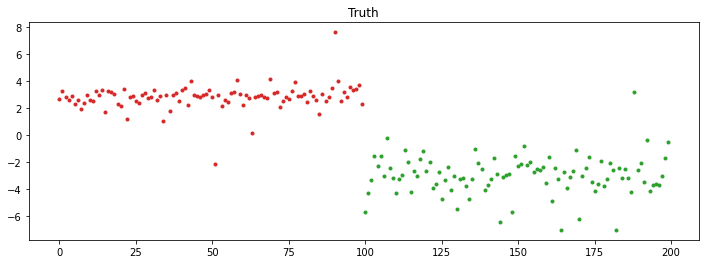

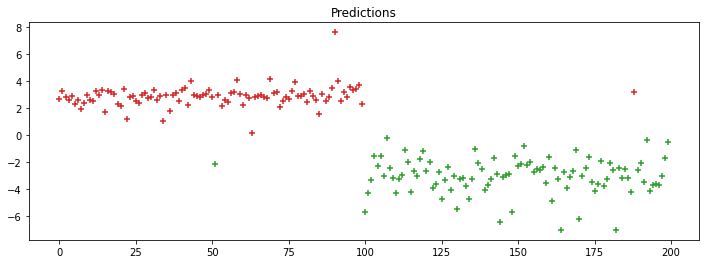

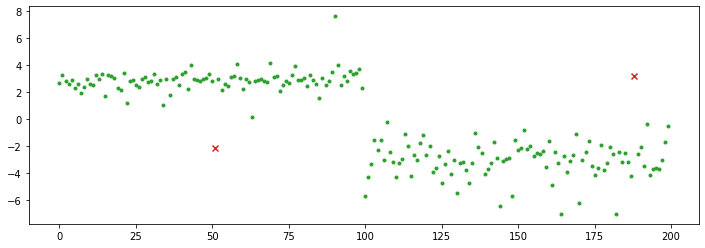

In [ ]:

##############################################################################################
res_ = np.array(data_hist_r)
g_LABELS = np.array([0,1])
res_pred_y = res_[:,-1]
res_true_y = res_[:,-3]
res_x = res_[:,0:-3]


matrix = confusion_matrix( res_true_y,  res_pred_y,   g_LABELS )
print('\n\tConfusion Matrix [N/A]')
print(print_conf_matrix( matrix, '', g_LABELS))
print_performance( matrix ,g_LABELS, do_round=5)

pred_correct = np.where(res_pred_y==res_true_y)[0]
pred_wrong = np.where(res_pred_y!=res_true_y)[0]
pC = len(pred_correct)
pW = len(pred_wrong)
print('')
assert ((pC+pW)==len(res_true_y))
print('Total Predictions\t',(pC+pW))
print('Correct Predictions\t', pC,'\t', round((100*pC)/(pC+pW),2),'%')
print('Incorrect Predictions\t', pW,'\t', round((100*pW)/(pC+pW),2),'%')

##############################################################################################
RT = xClassifier.lda2.transform(res_x)

x_0,x_1 = np.where(res_true_y==0)[0],np.where(res_true_y==1)[0]
xt_0,xt_1 = RT[x_0],RT[x_1]
plt.figure(figsize=(12,4))
plt.title('Truth')
plt.scatter( x_0,xt_0, color='tab:green', marker='.' )
plt.scatter( x_1,xt_1, color='tab:red', marker='.' )
plt.show()

x_0p,x_1p = np.where(res_pred_y==0)[0],np.where(res_pred_y==1)[0]
xt_0p,xt_1p = RT[x_0p],RT[x_1p]
plt.figure(figsize=(12,4))
plt.title('Predictions')
plt.scatter( x_0p,xt_0p, color='tab:green', marker='+' )
plt.scatter( x_1p,xt_1p, color='tab:red', marker='+' )
plt.show()

x_0p,x_1p = np.where(res_pred_y==0)[0],np.where(res_pred_y==1)[0]
xt_0p,xt_1p = RT[x_0p],RT[x_1p]
plt.figure(figsize=(12,4))
plt.scatter( pred_wrong,RT[pred_wrong], color='tab:red', marker='x' )
plt.scatter( pred_correct,RT[pred_correct], color='tab:green', marker='.' )

plt.show()



# [] METHOD #2 LSTM AE []

## Set Params

In [ ]:
lsamp, rsamp = int(0.1*BASIC_SRATE),int(0.4*BASIC_SRATE)+1
seqlen=lsamp+rsamp
print(lsamp,',',rsamp,',',seqlen)

12 , 52 , 64


## Select Dataset

In [ ]:
print(os.listdir(DATASET_DIR))
print(os.listdir(DATASET_DIR_NPY))

['ANTS.txt', 'db_01', 'db_test']
['annotations.txt', 'incartdb_npy', 'mitdb_npy', 'svdb_npy']


In [ ]:
sel_db_name = 'mitdb_npy'
sel_db_path = os.path.join(DATASET_DIR_NPY, sel_db_name)
sel_db_files = os.listdir(sel_db_path)
print(sel_db_path,',', len(sel_db_files) )
print(INCDB_SEL_REC)
print(MITDB_SEL_REC)
dbo = ecgDatabase(sel_db_name, sel_db_path)
print(dbo.record_list.shape,dbo.record_list)

/content/drive/MyDrive/cs575_mini_project/db_npy/mitdb_npy , 144
['I39', 'I01', 'I08', 'I18', 'I65', 'I72', 'I46', 'I36', 'I37', 'I35']
['116', '215', '210', '233', '214', '228', '221', '119', '203', '106']
(43,) ['100' '101' '103' '105' '106' '108' '109' '111' '112' '113' '114' '115'
 '116' '117' '118' '119' '121' '122' '123' '124' '200' '201' '202' '203'
 '205' '208' '209' '210' '212' '213' '214' '215' '219' '220' '221' '222'
 '223' '228' '230' '231' '232' '233' '234']


## Select Record

In [ ]:
recn = '215'
rec = dbo.get_record(recn)
print(rec.name, '\t'+str(rec.nos_beats)+ ' beats')
rec.mLabels = rec.map_beat_labels(custom_mapping)# <<-- custom lables

215 	3363 beats


In [ ]:
ql = np.where(rec.mLabels=="_N")[0]
print(ql.shape,ql)

(2302,) [   0    1    2 ... 2409 2410 2411]


## Select Signal (Beat)

(64,)
Label: _V


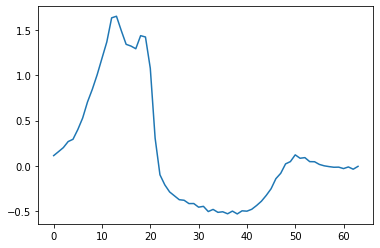

In [ ]:
bindex = 2924
signal, _ = rec.get_signal_slice_api(bindex, lsamp, rsamp )
print(signal.shape)
plt.plot(signal)
print('Label:', rec.mLabels[bindex])

### ADF Test, ACF, PACF


ADF-Test Hypothesis 	 Series is Non-Stationary
Test Statistic                                                -2.88517
p-value                                                         0.0471
#Lags Used                                                          11
Number of Observations Used                                         52
Critical Value (1%)             (-3.562878534649522, Hypothesis: True)
Critical Value (5%)             (-2.918973284023669, Hypothesis: True)
Critical Value (10%)           (-2.597393446745562, Hypothesis: False)
dtype: object
ADF-Test Result 	 False


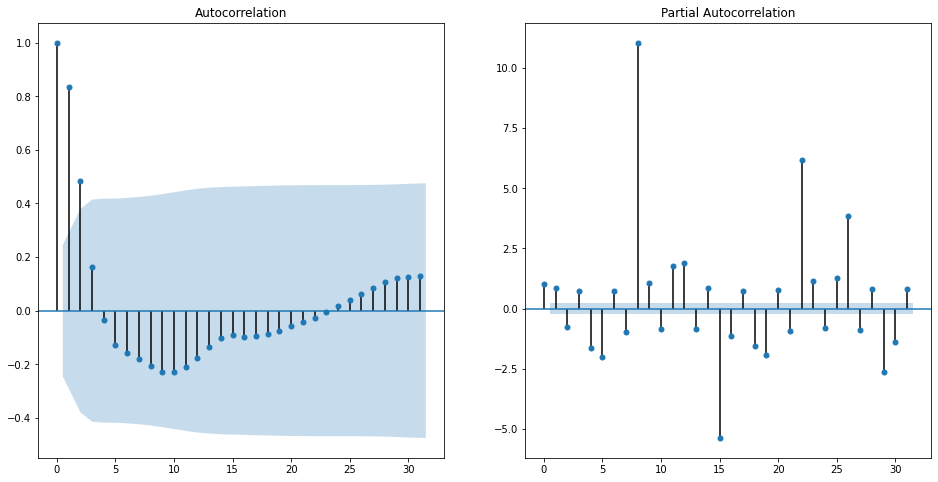

In [ ]:
# ADF Test
pval_thresh = 0.05
Ares, Aresb, Atest = adf_test(signal,pval_thresh, details=True)
print(Ares)

# plot ACF, PACF
Lags_CF = int(len(signal)/2)-1 #128*2 #int(len(signal)/2)-1
plotCF(signal, Lags_CF, True)


## LSTM-AE model

In [ ]:
def get_model_LAE(n_in, Print_Summary=True, do_compile= True):
    # define model
    lmodel = Sequential() #samples, timesteps, features
    lmodel.add(LSTM(64, activation='elu', input_shape=(n_in,1))) 
    lmodel.add(RepeatVector(n_in))
    lmodel.add(LSTM(64, activation='elu', return_sequences=True))
    lmodel.add(TimeDistributed(Dense(1)))

    if do_compile:
        lmodel.compile(optimizer=tf.optimizers.Adam(),loss='mse',)

    if Print_Summary:
        print(lmodel.summary())
    return lmodel

#========================================================================================

## Learn Rate Control

In [ ]:
def _deltaLR(e,lr):
  #----------------------------------------------------
  new_lr = lr # not controlled

    #if e%200==0:
    #    new_lr = lr*0.9999
    #    print('LR CALLBACK:',e,'\tSET LR: ', new_lr)
    #else:
    #    new_lr = lr
  #----------------------------------------------------
    return new_lr

## Callbacks

In [ ]:
cb_ES_loss = tf.keras.callbacks.EarlyStopping(
        monitor='loss',  #monitor: Quantity to be monitored.
        min_delta=0.001,  #min_delta: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
        patience=50,  #patience: Number of epochs with no improvement after which training will be stopped.
        verbose=1,  #verbose: verbosity mode.
        mode='auto',  #mode: One of {"auto", "min", "max"}. 
                      #In min mode, training will stop when the quantity monitored has stopped decreasing; 
                      #in "max" mode it will stop when the quantity monitored has stopped increasing; 
                      #in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
        baseline=None,  #baseline: Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline.
        restore_best_weights=True #restore_best_weights: Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.
        )
#cb_LRS = tf.keras.callbacks.LearningRateScheduler(_deltaLR, verbose=0)

cb_list = [cb_ES_loss] #<< - cb_LRS dont use Learn rate control

## Model Init

In [ ]:
model = get_model_LAE(seqlen)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 64)                16896     
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 64, 64)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 64, 64)            33024     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 64, 1)             65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
None


### Train single beat

(1, 64, 1)
Restoring model weights from the end of the best epoch.
Epoch 00256: early stopping


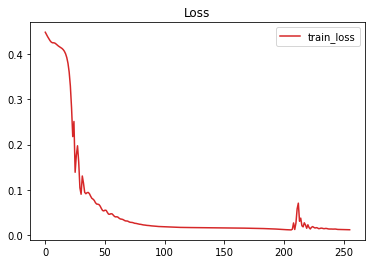

In [ ]:
seq_len = len(signal)
assert (seqlen==seq_len)
sequence = signal.reshape((1, seq_len, 1))
# reshape input into [samples, timesteps, features]
print(sequence.shape)

history = model.fit(sequence, sequence, epochs=1000, verbose=0, callbacks=cb_list)
plt.title('Loss')
plt.plot(history.history['loss'],color='tab:red', label='train_loss')
plt.legend()
plt.show()

### Test for threshold

...begin encoding and prediction on samples: 200


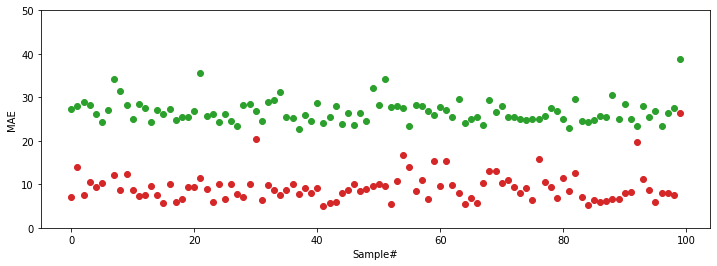

In [ ]:

mLabels_c = rec.mLabels[1:-1]
q = np.hstack(( np.random.choice( np.where((mLabels_c=="_V"))[0]+1, size= 100,replace=False),
 np.random.choice( np.where((mLabels_c=="_N"))[0]+1, size= 100,replace=False)))
print("...begin encoding and prediction on samples:",len(q))

pred_dict = {"_V":[],"_N":[]}
for bindex in q :
    signal_, _ = rec.get_signal_slice_api(bindex, lsamp, rsamp )
    assert (len(signal_)==seqlen)
    sequence = signal_.reshape((1, seqlen, 1))
    yhat = model.predict(sequence, verbose=0)
    dE = np.abs(yhat[0,:,0] - sequence[0,:,0])
    MAE = np.sum(dE)
    pred_dict[rec.mLabels[bindex]].append(MAE)

plt.figure(figsize=(12,4))
plt.ylim(0,50)
plt.scatter(np.arange(0,len(pred_dict["_V"]),1),pred_dict["_V"], color='tab:red')
plt.scatter(np.arange(0,len(pred_dict["_N"]),1),pred_dict["_N"], color='tab:green')
#plt.hlines(20,0,100)
plt.ylabel('MAE')
plt.xlabel('Sample#')
plt.show()

### Recreate beat

(64,)
Label: _V
(1, 64, 1)


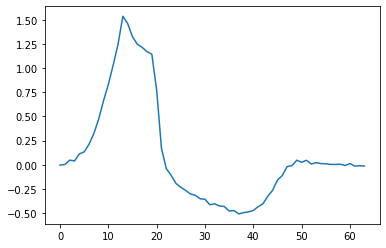

MAE: 7.3471143489796145


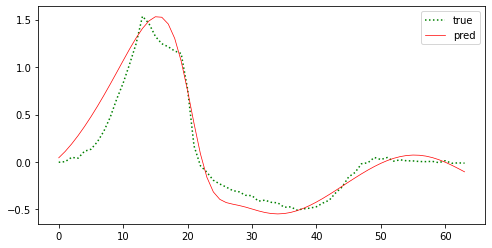

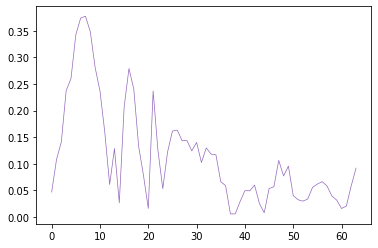

In [ ]:
bindex = 807
signal, _ = rec.get_signal_slice_api(bindex, lsamp, rsamp )
print(signal.shape)
plt.plot(signal)
print('Label:', rec.mLabels[bindex])
seq_len = len(signal)
assert (seqlen==seq_len)
sequence = signal.reshape((1, seq_len, 1))
# reshape input into [samples, timesteps, features]
print(sequence.shape)
plt.show()

yhat = model.predict(sequence, verbose=0)
dE = np.abs(yhat[0,:,0] - sequence[0,:,0])
MAE = np.sum(dE)
print('MAE:', MAE)

plt.figure(figsize=(8,4))
plt.plot(sequence[0,:,0],color='green',linestyle='dotted', label='true')
plt.plot(yhat[0,:,0],color='red',linewidth=0.7,label='pred')
plt.legend()
plt.show()
plt.plot(dE,color='tab:purple',linewidth=0.7)
plt.show()

## Train on Full Record

In [ ]:
def _train_LAE(rec, sequence_length, use_beats, _nL ,use_mapped_labels=True,random_train_beats=True):
    print('Init Classifier...')
    # <<-- Choose NN and AA
    if use_mapped_labels:
        print('Use mapped labels')
        mLabels_p,mLabels_c,mLabels_n = rec.mLabels[0:-2],rec.mLabels[1:-1],rec.mLabels[2:]
    else:
        print('Use original labels')
        mLabels_p,mLabels_c,mLabels_n = rec.iLabels[0:-2],rec.iLabels[1:-1],rec.iLabels[2:]

    ##############################################################################################################

    NN_ = np.where((mLabels_p==_nL)&(mLabels_c==_nL)&(mLabels_n==_nL))[0]+1 # True Normal:
    #N_ = np.where((mLabels_c==self._n))[0]+1 # Any Normal: All Normal beats
    #AA_ = np.where((mLabels_c!=self._n))[0] + 1 # All Abnormal beats
    #A_ = np.where((mLabels_c==_aL))[0] + 1 # Abnormal beats

    nncount = min(len(NN_),use_beats)
    #aacount = min(len(A_),use_beats)

    # either take from begin or randomly
    if random_train_beats:
        print('Random beats for training...')
        for_train_N = np.random.choice(NN_,size=nncount,replace=False)  #<--- rand True Normal
        #for_train_A = np.random.choice(A_,size=aacount,replace=False)  #<--- rand Abnormal beats
    else:  
        print('Initial beats for training...')  
        for_train_N = NN_[0:nncount]  #<--- first 10 beats True Normal
        #for_train_A = A_[0:aacount]  #<--- first 10 beats Abnormal beats

    data_listN=[]
    print('Learning...',nncount )    

     # reshape input into [samples, timesteps, features]
    for i in range(0,nncount):
        bindex = for_train_N[i]
        signal_, _ = rec.get_signal_slice_api(bindex, lsamp, rsamp )
        assert (sequence_length==len(signal_))
        data_listN.append(signal_)
        
    #for i in range(0,aacount):
    #    bindex = for_train_A[i]
    #    signal_, _ = rec.get_signal_slice_api(bindex, lsamp, rsamp )
    #    assert (sequence_length==len(signal_))
    #    data_listA.append(signal_)


    # first choose use_beats
    sequenceN = np.array(data_listN).reshape((len(data_listN), sequence_length, 1))
    #sequenceA = np.array(data_listA).reshape((len(data_listA), sequence_length, 1))

    data_ = sequenceN #np.vstack((sequenceN,sequenceA))
    np.random.shuffle(data_)

    modelLAE = get_model_LAE(sequence_length)

    history = modelLAE.fit(data_, data_, epochs=1000, verbose=1, callbacks=cb_list)
    plt.title('Loss')
    plt.plot(history.history['loss'],color='tab:red', label='train_loss')
    plt.legend()
    plt.show()


    return modelLAE

### Select *Record*

In [ ]:
#['I39', 'I01', 'I08', 'I18', 'I65', 'I72', 'I46', 'I36', 'I37', 'I35']
#['116', '215', '210', '233', '214', '228', '221', '119', '203', '106']
recn = '106'
rec = dbo.get_record(recn)
print(rec.name, '\t'+str(rec.nos_beats)+ ' beats')
rec.mLabels = rec.map_beat_labels(custom_mapping)# <<-- custom lables
ql = np.where(rec.mLabels=="_V")[0]
print(ql.shape)

106 	2027 beats
(520,)


### Start Training

Init Classifier...
Use mapped labels
Random beats for training...
Learning... 100
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_54 (LSTM)               (None, 64)                16896     
_________________________________________________________________
repeat_vector_27 (RepeatVect (None, 64, 64)            0         
_________________________________________________________________
lstm_55 (LSTM)               (None, 64, 64)            33024     
_________________________________________________________________
time_distributed_27 (TimeDis (None, 64, 1)             65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
4/4 [==============================] - 3s 62ms/step - loss: 0.2118
Epoch 2/1000
4/4 [==============================] - 0s 63ms/step - loss: 0.1856


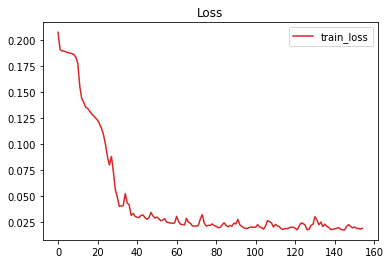

106


In [ ]:
use_beatsX=100
modelX = _train_LAE(rec, seqlen, use_beatsX, "_N",use_mapped_labels=True,random_train_beats=True)
print(rec.name)

### Start Testing


Testing...
Use mapped labels
...begin encoding and prediction on samples: 1040 520 520


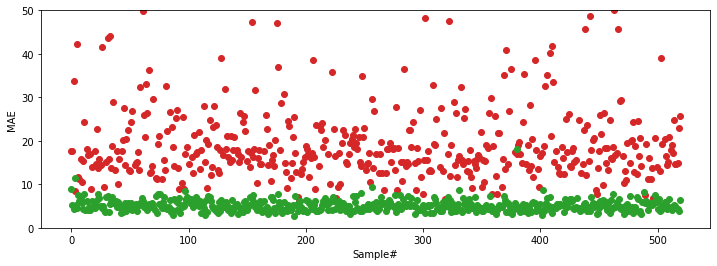

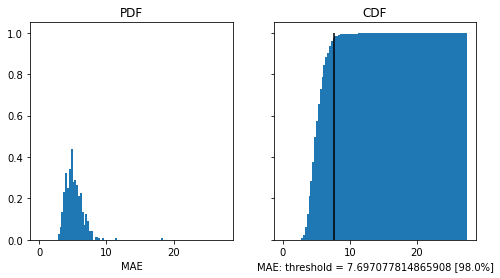

Accuracy: 97.98


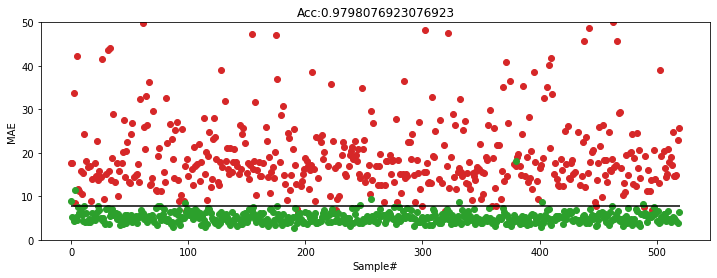

In [ ]:
use_beats_testN=200
use_beats_testA=100
use_mapped_labels=True
print('\nTesting...')

#qN = np.random.choice( np.where((mLabels_c=="_N"))[0]+1, size= use_beats_testN, replace=False)
#qA = np.random.choice( np.where((mLabels_c=="_V"))[0]+1, size= use_beats_testA, replace=False)
if use_mapped_labels:
    print('Use mapped labels')
    mLabels_p,mLabels_c,mLabels_n = rec.mLabels[0:-2],rec.mLabels[1:-1],rec.mLabels[2:]
else:
    print('Use original labels')
    mLabels_p,mLabels_c,mLabels_n = rec.iLabels[0:-2],rec.iLabels[1:-1],rec.iLabels[2:]

qN = np.where((mLabels_c=="_N"))[0]+1
qA = np.where((mLabels_c=="_V"))[0]+1

takes = min(len(qN),len(qA))

qN = np.random.choice(qN, size=takes, replace=False)
qA = np.random.choice(qA, size=takes, replace=False)

q = np.hstack((qA,qN))
#q= np.arange(0,rec.nos_beats-1)
print("...begin encoding and prediction on samples:",len(q), len(qN), len(qA))

pred_dict = {"_V":[],"_N":[]}
for bindex in q :
    signal_, _ = rec.get_signal_slice_api(bindex, lsamp, rsamp )
    assert (seqlen == len(signal_))
    sequence = signal_.reshape((1,seqlen, 1))
    yhat = modelX.predict(sequence, verbose=0)
    dE = np.abs(yhat[0,:,0] - sequence[0,:,0])
    MAE = np.sum(dE)
    pred_dict[rec.mLabels[bindex]].append(MAE)

plt.figure(figsize=(12,4))
plt.ylim(0,50)


plt.scatter(np.arange(0,len(pred_dict["_V"]),1),pred_dict["_V"], color='tab:red')
plt.scatter(np.arange(0,len(pred_dict["_N"]),1),pred_dict["_N"], color='tab:green')
#plt.hlines(20,0,100)
plt.ylabel('MAE')
plt.xlabel('Sample#')
plt.show()
#-------------------------------------



Npd = np.array(pred_dict["_N"])
Apd = np.array(pred_dict["_V"])

pthresh = 0.98 #90 % data
data_ = np.hstack((Npd, Apd))


fig,ax = plt.subplots(1,2,figsize=(8,4),  sharey=True)

n_pbin, n_bin, _ = ax[0].hist( Npd, bins=100, range=(0, np.max(Nss)), density=True)
C_pbin, C_bin, _ = ax[1].hist( Npd, bins=100, range=(0, np.max(Nss)), density=True, cumulative=True)

q_index = np.where(C_pbin>=pthresh)[0][0]
q_thresh = C_bin[q_index]
ax[1].vlines(q_thresh,0,1)
ax[0].set_title('PDF')
ax[0].set_xlabel('MAE')
ax[1].set_title('CDF')
ax[1].set_xlabel('MAE: threshold = '+str(q_thresh)+ ' ['+str(round(pthresh*100,2))+'%]')
plt.show()
#c_pbin, c_bin, _ = plt.hist( train_x, bins=100, range=(0, np.max(Nss)), cumulative=True)

TP_ = len(np.where(Npd<=q_thresh)[0]) # TP
FN_ = len(np.where(Npd>q_thresh)[0])  # FN

FP_ = len(np.where(Apd<=q_thresh)[0]) # FP
TN_ = len(np.where(Apd>q_thresh)[0])  # TN

acc_ = (TP_+TN_) / len(data_)
print('Accuracy: %.2f' % (acc_*100))



plt.figure(figsize=(12,4))
plt.ylim(0,50)
plt.title('Acc:'+str(acc_))
plt.scatter(np.arange(0,len(pred_dict["_V"]),1),pred_dict["_V"], color='tab:red')
plt.scatter(np.arange(0,len(pred_dict["_N"]),1),pred_dict["_N"], color='tab:green')
plt.hlines(q_thresh,0,takes,color='black')

_=plt.ylabel('MAE')
_=plt.xlabel('Sample#')

#for i in range(0,len(pths)):





---

# [] _______ []

---



# [_] ARCHIVE [_]